# Import Required Libraries

In [29]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To import overbalanced data
from scipy.sparse import load_npz
from scipy.sparse import hstack, csr_matrix

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)


# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import contractions

# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('maxent_ne_chunker')


from textblob import TextBlob

[nltk_data] Downloading package words to /Users/jonathan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jonathan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


# Load in Datasets


In [4]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None)

In [5]:
# Training df
df_train = load_file('raw_data/fulltrain.csv')
df_train = df_train.set_axis(['label', 'text'], axis=1)

# Testing df
df_test = load_file('raw_data/balancedtest.csv')
df_test = df_test.set_axis(['label', 'text'], axis=1)

# Map the labels

In [6]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

# Verify datasets loaded in correctly

In [7]:
df_train.head(10) # Training set

,label,text
0,Satire,"A little less than a decade ago, hockey fans w..."
1,Satire,The writers of the HBO series The Sopranos too...
2,Satire,Despite claims from the TV news outlet to offe...
3,Satire,After receiving 'subpar' service and experienc...
4,Satire,After watching his beloved Seattle Mariners pr...
5,Satire,"At a cafeteria-table press conference Monday, ..."
6,Satire,Stunned shock and dismay were just a few of th...
7,Satire,"Speaking with reporters before a game Monday, ..."
8,Satire,Sports journalists and television crews were p...
9,Satire,"SALEM, VAF;or the eighth straight world-histor..."


In [8]:
df_test.head(10) # Test set

,label,text
0,Satire,When so many actors seem content to churn out ...
1,Satire,In what football insiders are calling an unex...
2,Satire,In a freak accident following Game 3 of the N....
3,Satire,North Koreas official news agency announced to...
4,Satire,The former Alaska Governor Sarah Palin would b...
5,Satire,With the first Presidential debate just two da...
6,Satire,"There are fans, and then there are super-fans...."
7,Satire,"With its landmark decisions this week, the Uni..."
8,Satire,Koch Industries is defending its acquisition o...
9,Satire,Republican lawmakers asked increasingly tough ...


# Label distribution

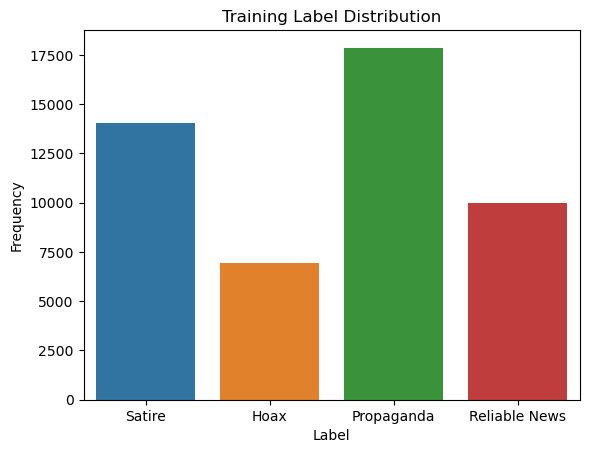

label
Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: count, dtype: int64

In [9]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

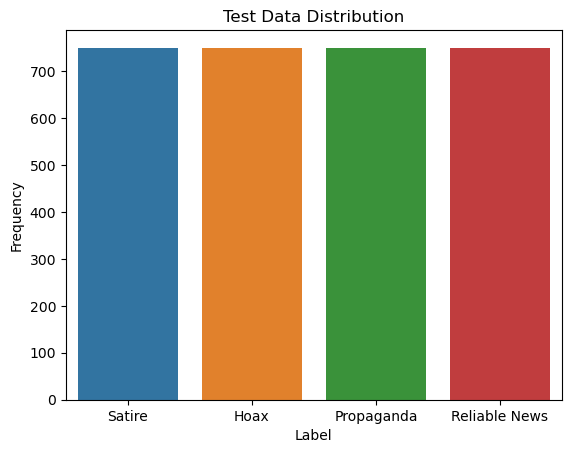

label
Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: count, dtype: int64

In [10]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [11]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [12]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [13]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [14]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word( text_no_stopwords)
    return text_processed

In [17]:
# # Processing datasets
# print("Processing dataset: df_train")
# df_train['processed_text'] = df_train['text'].apply(preprocess_text)
# print("Finished processing dataset: df_train")

# print("Processing dataset: df_test")
# df_test['processed_text'] = df_test['text'].apply(preprocess_text)
# print("Finished processing dataset: df_test")

# Reloading the DataFrames from CSV
df_train = pd.read_csv('processed_train.csv')
df_test = pd.read_csv('processed_test.csv')

# Feature Engineering

# Load in all the features

In [20]:
# Load and assign to df_train
df_train['word_count'] = np.load('features/word_count_train.npy')
df_train['named_entity_count'] = np.load('features/named_entity_count_train.npy')
df_train['avg_first_person_pronouns'] = np.load('features/avg_first_person_pronouns_train.npy')
df_train['avg_second_person_pronouns'] = np.load('features/avg_second_person_pronouns_train.npy')
df_train['avg_third_person_pronouns'] = np.load('features/avg_third_person_pronouns_train.npy')
df_train['sentiment'] = np.load('features/sentiment_train.npy')
df_train['subjectivity'] = np.load('features/subjectivity_train.npy')
df_train['readability'] = np.load('features/readability_train.npy')
df_train['punctuation_count'] = np.load('features/train_punctuation_count.npy')
df_train['punctuation_diversity'] = np.load('features/train_punctuation_diversity.npy')
df_train['punctuation_pair'] = np.load('features/train_punctuation_pair.npy')
df_train['semantic_dispersion'] = np.load('features/train_semantic_dispersion.npy')


# Load and assign to df_test
df_test['word_count'] = np.load('features/word_count_test.npy')
df_test['named_entity_count'] = np.load('features/named_entity_count_test.npy')
df_test['avg_first_person_pronouns'] = np.load('features/avg_first_person_pronouns_test.npy')
df_test['avg_second_person_pronouns'] = np.load('features/avg_second_person_pronouns_test.npy')
df_test['avg_third_person_pronouns'] = np.load('features/avg_third_person_pronouns_test.npy')
df_test['sentiment'] = np.load('features/sentiment_test.npy')
df_test['subjectivity'] = np.load('features/subjectivity_test.npy')
df_test['readability'] = np.load('features/readability_test.npy')
df_test['punctuation_count'] = np.load('features/test_punctuation_count.npy')
df_test['punctuation_diversity'] = np.load('features/test_punctuation_diversity.npy')
df_test['punctuation_pair'] = np.load('features/test_punctuation_pair.npy')
df_test['semantic_dispersion'] = np.load('features/test_semantic_dispersion.npy')


# pos_train
pos_train = np.load('features/train_pos.npy')
pos_test = np.load('features/test_pos.npy')

for i in range(pos_train.shape[1]):
    df_train[f'pos_feature_{i}'] = pos_train[:, i]

# Repeat for df_test and pos_test
for i in range(pos_test.shape[1]):
    df_test[f'pos_feature_{i}'] = pos_test[:, i]
    
# Replace all NaN values with 0 in df_train and df_test
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)


# Named entity count -> Named entity counttso that longer text does not result in higher entity count
df_train['named_entity_count_per_word'] = df_train['named_entity_count'] / df_train['word_count']

# Replace any potential infinite values or NaNs that occur if word_count is zero
df_train['named_entity_count_per_word'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_train['named_entity_count_per_word'].fillna(0, inplace=True) 

# Calculate the new feature in the testing dataset
df_test['named_entity_count_per_word'] = df_test['named_entity_count'] / df_test['word_count']

# Replace any potential infinite values or NaNs that occur if word_count is zero
df_test['named_entity_count_per_word'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_test['named_entity_count_per_word'].fillna(0, inplace=True)  

In [21]:
pd.set_option('display.max_columns', None)  # See if all the columns are loaded in properly
df_train.head(10)

,label,text,processed_text,word_count,named_entity_count,avg_first_person_pronouns,avg_second_person_pronouns,avg_third_person_pronouns,sentiment,subjectivity,readability,punctuation_count,punctuation_diversity,punctuation_pair,semantic_dispersion,pos_feature_0,pos_feature_1,pos_feature_2,pos_feature_3,pos_feature_4,pos_feature_5,pos_feature_6,pos_feature_7,pos_feature_8,pos_feature_9,pos_feature_10,pos_feature_11,pos_feature_12,pos_feature_13,pos_feature_14,pos_feature_15,pos_feature_16,named_entity_count_per_word
0,Satire,"A little less than a decade ago, hockey fans w...","A little le decade ago, hockey fan blessed sla...",119,11,0.000000,0.000000,0.012270,0.151731,0.526154,67.18,0.020882,2,4,0.279250,0.072289,0.054217,0.006024,0.078313,0.186747,0.072289,0.102410,0.108434,0.060241,0.120482,0.042169,0.018072,0.042169,0.012048,0.006024,0.018072,0.000000,0.092437
1,Satire,The writers of the HBO series The Sopranos too...,The writer HBO series The Sopranos took anothe...,92,6,0.007407,0.000000,0.014815,0.087879,0.327652,57.44,0.022825,4,9,0.305554,0.107914,0.050360,0.000000,0.107914,0.194245,0.057554,0.100719,0.071942,0.028777,0.115108,0.007194,0.021583,0.079137,0.007194,0.028777,0.021583,0.000000,0.065217
2,Satire,Despite claims from the TV news outlet to offe...,Despite claim TV news outlet offer 'nonstop ne...,587,39,0.001238,0.003713,0.006188,0.066746,0.417664,50.46,0.035084,11,35,0.211803,0.097110,0.067052,0.004624,0.091329,0.226590,0.050867,0.134104,0.107514,0.016185,0.087861,0.026590,0.016185,0.024277,0.001156,0.032370,0.016185,0.000000,0.066440
3,Satire,After receiving 'subpar' service and experienc...,After receiving 'subpar' service experiencing ...,505,18,0.027127,0.003699,0.067818,0.145326,0.436273,61.90,0.034899,5,18,0.229919,0.084906,0.062500,0.001179,0.080189,0.152123,0.036557,0.141509,0.038915,0.045991,0.141509,0.024764,0.024764,0.117925,0.001179,0.011792,0.033019,0.001179,0.035644
4,Satire,After watching his beloved Seattle Mariners pr...,After watching beloved Seattle Mariners prevai...,145,11,0.028986,0.000000,0.043478,0.194918,0.593101,59.16,0.037143,7,19,0.167049,0.058559,0.040541,0.009009,0.045045,0.130631,0.058559,0.166667,0.112613,0.045045,0.117117,0.022523,0.036036,0.085586,0.022523,0.013514,0.036036,0.000000,0.075862
5,Satire,"At a cafeteria-table press conference Monday, ...","At cafeteria-table press conference Monday, Da...",81,9,0.017699,0.000000,0.026549,-0.019048,0.354762,47.83,0.042230,4,11,0.238528,0.033333,0.050000,0.000000,0.050000,0.150000,0.083333,0.175000,0.125000,0.058333,0.083333,0.025000,0.016667,0.050000,0.008333,0.033333,0.058333,0.000000,0.111111
6,Satire,Stunned shock and dismay were just a few of th...,Stunned shock dismay reaction Bobby Guntergras...,88,4,0.000000,0.000000,0.053691,0.216667,0.692857,66.37,0.028112,4,10,0.245108,0.122581,0.064516,0.000000,0.090323,0.174194,0.045161,0.122581,0.058065,0.038710,0.090323,0.012903,0.032258,0.083871,0.019355,0.006452,0.038710,0.000000,0.045455
7,Satire,"Speaking with reporters before a game Monday, ...","Speaking reporter game Monday, local Little Le...",456,19,0.036000,0.001333,0.061333,-0.113114,0.436695,67.83,0.018474,5,13,0.234411,0.066320,0.044213,0.000000,0.124837,0.154746,0.072822,0.088427,0.039012,0.033810,0.148244,0.024707,0.037711,0.117035,0.006502,0.009103,0.032510,0.000000,0.041667
8,Satire,Sports journalists and television crews were p...,Sports journalist television crew pushed aside...,125,11,0.031579,0.000000,0.036842,0.261111,0.592593,54.09,0.024416,5,10,0.311998,0.073298,0.020942,0.015707,0.099476,0.172775,0.020942,0.104712,0.157068,0.031414,0.109948,0.031414,0.020942,0.083770,0.000000,0.031414,0.026178,0.000000,0.088000
9,Satire,"SALEM, VAF;or the eighth straight world-histor...","SALEM, VAF;or eighth straight world-history pe...",74,6,0.010000,0.000000,0.040000,0.160952,0.393810,71.34,0.046555,5,11,0.240489,0.052632,0.061404,0.000000,0.061404,0.228070,0.017544,0.166667,0.149123,0.043860,0.078947,0.035088,0.017544,0.04

## Word Count

In [111]:
# def count_words(text):
#     words = word_tokenize(text)
#     return len(words)

# # Assuming df_train and df_test are already defined and have a column 'processed_text'
# df_train['word_count'] = df_train['processed_text'].apply(count_words)
# df_test['word_count'] = df_test['processed_text'].apply(count_words)

# # Convert DataFrame columns to NumPy arrays
# word_count_train = df_train['word_count'].to_numpy()
# word_count_test = df_test['word_count'].to_numpy()

# # Save the arrays to .npy files
# np.save('word_count_train.npy', word_count_train)
# np.save('word_count_test.npy', word_count_test)

## Named Entity Recognition

In [112]:
# def count_named_entities(corpus):
#     count = 0
#     tagged_corpus = pos_tag(word_tokenize(corpus))
#     named_entities = ne_chunk(tagged_corpus)
#     for elem in named_entities:
#         if hasattr(elem, 'label'):
#             count += 1
#     return count

# df_train['named_entity_count'] = df_train['processed_text'].apply(count_named_entities)
# df_test['named_entity_count'] = df_test['processed_text'].apply(count_named_entities)

# # Convert DataFrame columns to NumPy arrays
# named_entity_count_train = df_train['named_entity_count'].to_numpy()
# named_entity_count_test = df_test['named_entity_count'].to_numpy()

# # Save the arrays to .npy files
# np.save('named_entity_count_train.npy', named_entity_count_train)
# np.save('named_entity_count_test.npy', named_entity_count_test)

## Pronoun counts

In [113]:
# def count_pronouns_per_word(text, pronoun_list):
#     words = word_tokenize(text)
#     total_words = len(words)
#     pronoun_count = 0
    
#     for word in words:
#         if word.lower() in pronoun_list:
#             pronoun_count += 1
    
#     if total_words > 0:
#         return pronoun_count / total_words
#     else:
#         return 0 

# # Lists of pronouns by person
# first_person_pronouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
# second_person_pronouns = ['you', 'your', 'yours']
# third_person_pronouns = ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs']

# # Adding average pronoun counts to the DataFrame for training data
# df_train['avg_first_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(first_person_pronouns,))
# df_train['avg_second_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(second_person_pronouns,))
# df_train['avg_third_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(third_person_pronouns,))

# # Adding average pronoun counts to the DataFrame for testing data
# df_test['avg_first_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(first_person_pronouns,))
# df_test['avg_second_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(second_person_pronouns,))
# df_test['avg_third_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(third_person_pronouns,))

# avg_first_person_pronouns_train = df_train['avg_first_person_pronouns'].to_numpy()
# avg_second_person_pronouns_train = df_train['avg_second_person_pronouns'].to_numpy()
# avg_third_person_pronouns_train = df_train['avg_third_person_pronouns'].to_numpy()

# # Converting the necessary columns from df_test to NumPy arrays
# avg_first_person_pronouns_test = df_test['avg_first_person_pronouns'].to_numpy()
# avg_second_person_pronouns_test = df_test['avg_second_person_pronouns'].to_numpy()
# avg_third_person_pronouns_test = df_test['avg_third_person_pronouns'].to_numpy()


# # Save the arrays to .npy files for training data
# np.save('avg_first_person_pronouns_train.npy', avg_first_person_pronouns_train)
# np.save('avg_second_person_pronouns_train.npy', avg_second_person_pronouns_train)
# np.save('avg_third_person_pronouns_train.npy', avg_third_person_pronouns_train)

# # Save the arrays to .npy files for testing data
# np.save('avg_first_person_pronouns_test.npy', avg_first_person_pronouns_test)
# np.save('avg_second_person_pronouns_test.npy', avg_second_person_pronouns_test)
# np.save('avg_third_person_pronouns_test.npy', avg_third_person_pronouns_test)


## Sentiment Analysis

In [114]:
# # Function to compute sentiment polarity
# def get_sentiment(text):
#     return TextBlob(text).sentiment.polarity

# # Computing sentiment for each article
# df_train['sentiment'] = df_train['processed_text'].apply(get_sentiment)
# df_test['sentiment'] = df_test['processed_text'].apply(get_sentiment)



## Subjectivity Analysis

In [116]:
# # Function to compute subjectivity
# def get_subjectivity(text):
#     return TextBlob(text).sentiment.subjectivity

# # Computing subjectivity for each article
# df_train['subjectivity'] = df_train['processed_text'].apply(get_subjectivity)
# df_test['subjectivity'] = df_test['processed_text'].apply(get_subjectivity)


## Readability analysis

In [117]:
# import textstat
# # Function to compute readability score
# def get_readability(text):
#     return textstat.flesch_reading_ease(text)

# # Computing readability score for each article
# df_train['readability'] = df_train['text'].apply(get_readability)
# df_test['readability'] = df_test['text'].apply(get_readability)



In [118]:
# # Convert the sentiment, subjectivity, and readability columns to NumPy arrays
# sentiment_train = df_train['sentiment'].to_numpy()
# sentiment_test = df_test['sentiment'].to_numpy()

# subjectivity_train = df_train['subjectivity'].to_numpy()
# subjectivity_test = df_test['subjectivity'].to_numpy()

# readability_train = df_train['readability'].to_numpy()
# readability_test = df_test['readability'].to_numpy()

# # Save the arrays to .npy files for sentiment
# np.save('sentiment_train.npy', sentiment_train)
# np.save('sentiment_test.npy', sentiment_test)

# # Save the arrays to .npy files for subjectivity
# np.save('subjectivity_train.npy', subjectivity_train)
# np.save('subjectivity_test.npy', subjectivity_test)

# # Save the arrays to .npy files for readability
# np.save('readability_train.npy', readability_train)
# np.save('readability_test.npy', readability_test)


## Low frequency collocations

In [ ]:
# from nltk.collocations import BigramCollocationFinder
# from nltk.metrics import BigramAssocMeasures
# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize

# def find_low_freq_collocations(texts, freq_threshold=2): #threshold is how rare the coll has to be, if appear < thres -> rare
#     all_bigrams = []
#     for text in texts:
#         tokens = word_tokenize(text)
#         bigram_finder = BigramCollocationFinder.from_words(tokens)
#         all_bigrams.extend(list(bigram_finder.ngram_fd.items()))

#     bigram_freq = FreqDist()
#     for bigram, freq in all_bigrams:
#         bigram_freq[bigram] += freq

#     low_freq_collocations = [bigram for bigram, freq in bigram_freq.items() if freq == freq_threshold]
#     return low_freq_collocations

# def flag_collocations(text, collocations):
#     tokens = word_tokenize(text)
#     bigrams_existing = bigrams(tokens)
#     f = {}
#     bigram_set = set(collocations)
#     for bg in bigrams_existing:
#         if bg in bigram_set:
#             feature = f"colloc_{'_'.join(bg)}"
#             if feature not in f:
#                 f[feature] = 1
#             else:
#                 f[feature] += 1  # freq instead of binary flag

#     return pd.Series(f)

# rare_collocations = find_low_freq_collocations(df_train['processed_text'], freq_threshold=2)

# batch_size = 1000
# for start in range(0, df_train.shape[0], batch_size):
#     print("done")
#     end = min(start + batch_size, df_train.shape[0])
#     batch = df_train[start:end]
#     collocation_feature_batch = batch['processed_text'].apply(lambda text: flag_collocations(text, rare_collocations))
#     np.save(f'train_rare_collocations_{start}_{end}.npy', collocation_feature_batch)


# Data Visualisations (To help us determine what features are useful)

## Named Entity Counts per Word 

## Train

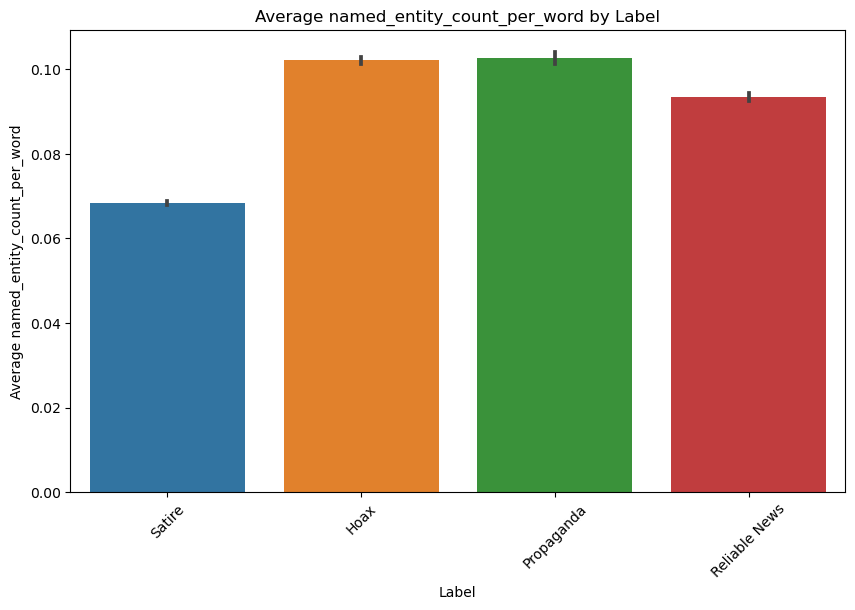

In [30]:
def plot_feature_by_label(df, feature_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='label', y=feature_name, data=df)
    plt.title(f'Average {feature_name} by Label')
    plt.xlabel('Label')
    plt.ylabel(f'Average {feature_name}')
    plt.xticks(rotation=45)  # Rotate labels if they overlap
    plt.show()


# training set
plot_feature_by_label(df_train, 'named_entity_count_per_word')

## Test

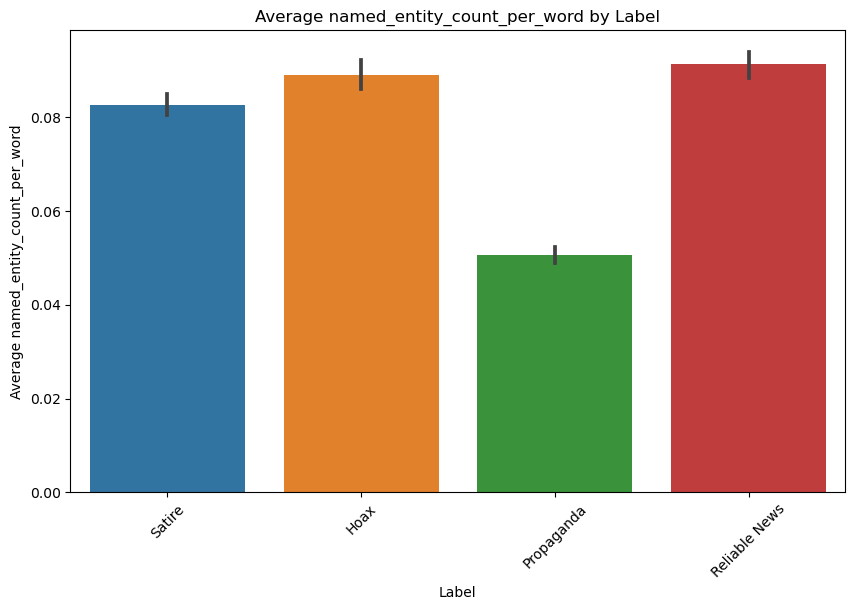

In [31]:
# test set
plot_feature_by_label(df_test, 'named_entity_count_per_word')

## Pronoun Scores

## Train set

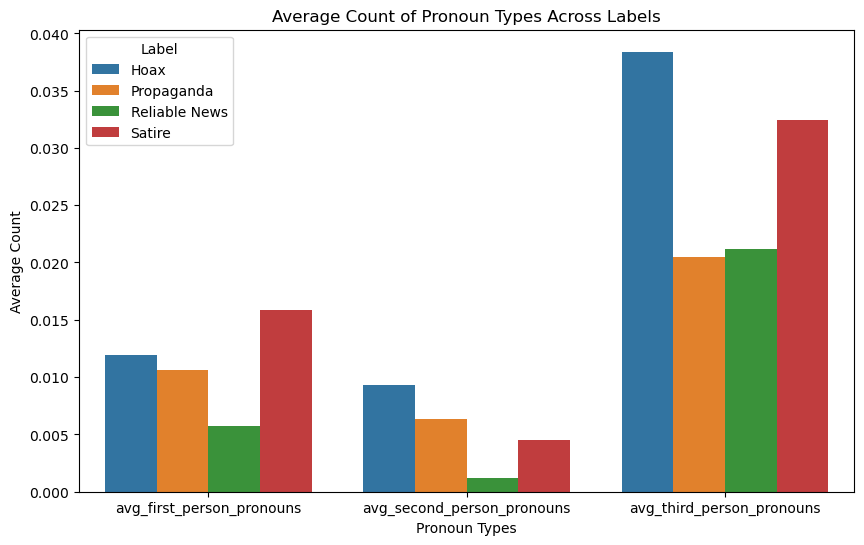

In [32]:
# Train set
grouped_means = df_train.groupby('label')[['avg_first_person_pronouns', 'avg_second_person_pronouns', 'avg_third_person_pronouns']].mean()

# Reset index if necessary to use 'label' as a normal column
grouped_means = grouped_means.reset_index()

# Melt the DataFrame to suit seaborn's barplot requirements
melted_means = grouped_means.melt(id_vars=['label'], var_name='Pronoun Type', value_name='Average Count')

# Create a bar plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Pronoun Type', y='Average Count', hue='label', data=melted_means)
plt.title('Average Count of Pronoun Types Across Labels')
plt.ylabel('Average Count')
plt.xlabel('Pronoun Types')
plt.legend(title='Label')
plt.show()



## Test set

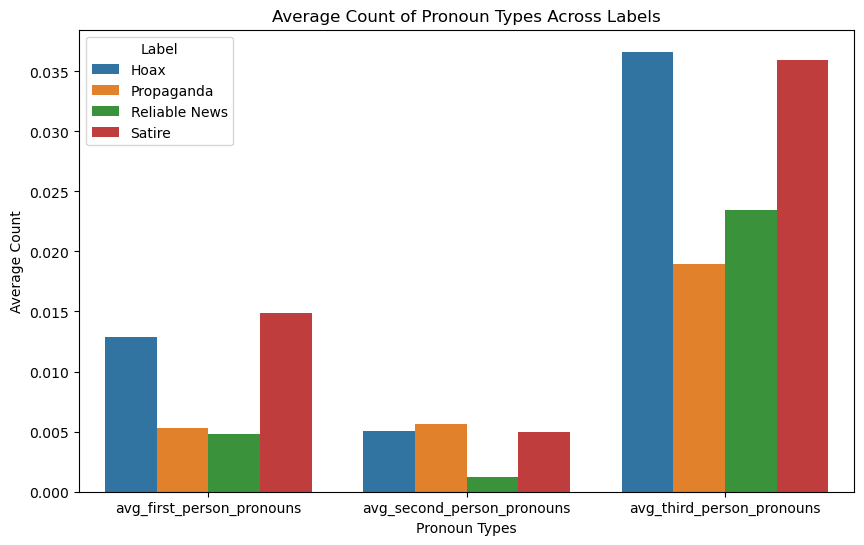

In [33]:
# Test set
grouped_means = df_test.groupby('label')[['avg_first_person_pronouns', 'avg_second_person_pronouns', 'avg_third_person_pronouns']].mean()

# Reset index if necessary to use 'label' as a normal column
grouped_means = grouped_means.reset_index()

# Melt the DataFrame to suit seaborn's barplot requirements
melted_means = grouped_means.melt(id_vars=['label'], var_name='Pronoun Type', value_name='Average Count')

# Create a bar plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Pronoun Type', y='Average Count', hue='label', data=melted_means)
plt.title('Average Count of Pronoun Types Across Labels')
plt.ylabel('Average Count')
plt.xlabel('Pronoun Types')
plt.legend(title='Label')
plt.show()

## Sentiment, Readability and Subjectivity Scores

### Train set

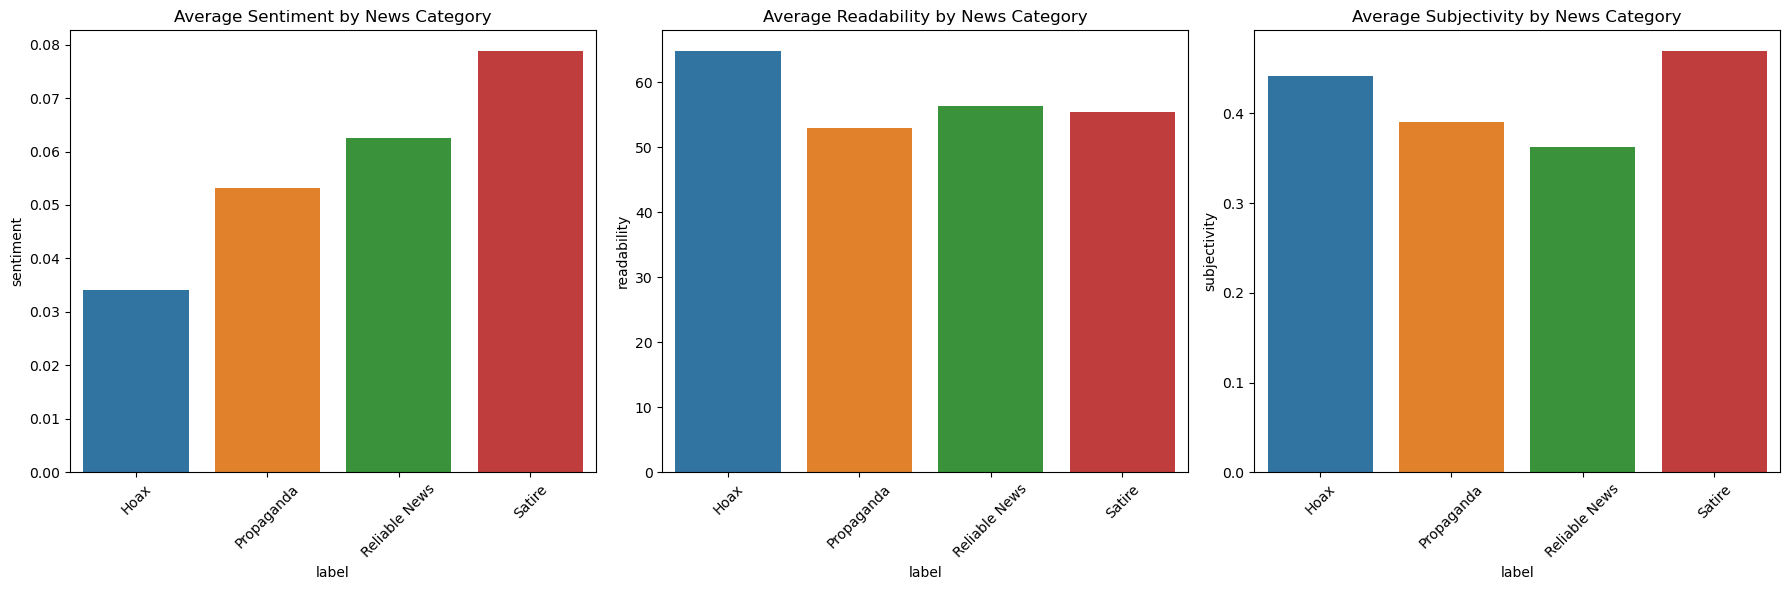

In [34]:

mean_values = df_train.groupby('label').agg({
    'sentiment': 'mean',
    'readability': 'mean',
    'subjectivity': 'mean'
}).reset_index()

# Plotting

plt.figure(figsize=(18, 6))

# Sentiment

plt.subplot(1, 3, 1)
sns.barplot(x='label', y='sentiment', data=mean_values)
plt.title('Average Sentiment by News Category')
plt.xticks(rotation=45)

# Readability
plt.subplot(1, 3, 2)
sns.barplot(x='label', y='readability', data=mean_values)
plt.title('Average Readability by News Category')
plt.xticks(rotation=45)

# Subjectivity
plt.subplot(1, 3, 3)
sns.barplot(x='label', y='subjectivity', data=mean_values)
plt.title('Average Subjectivity by News Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Test set

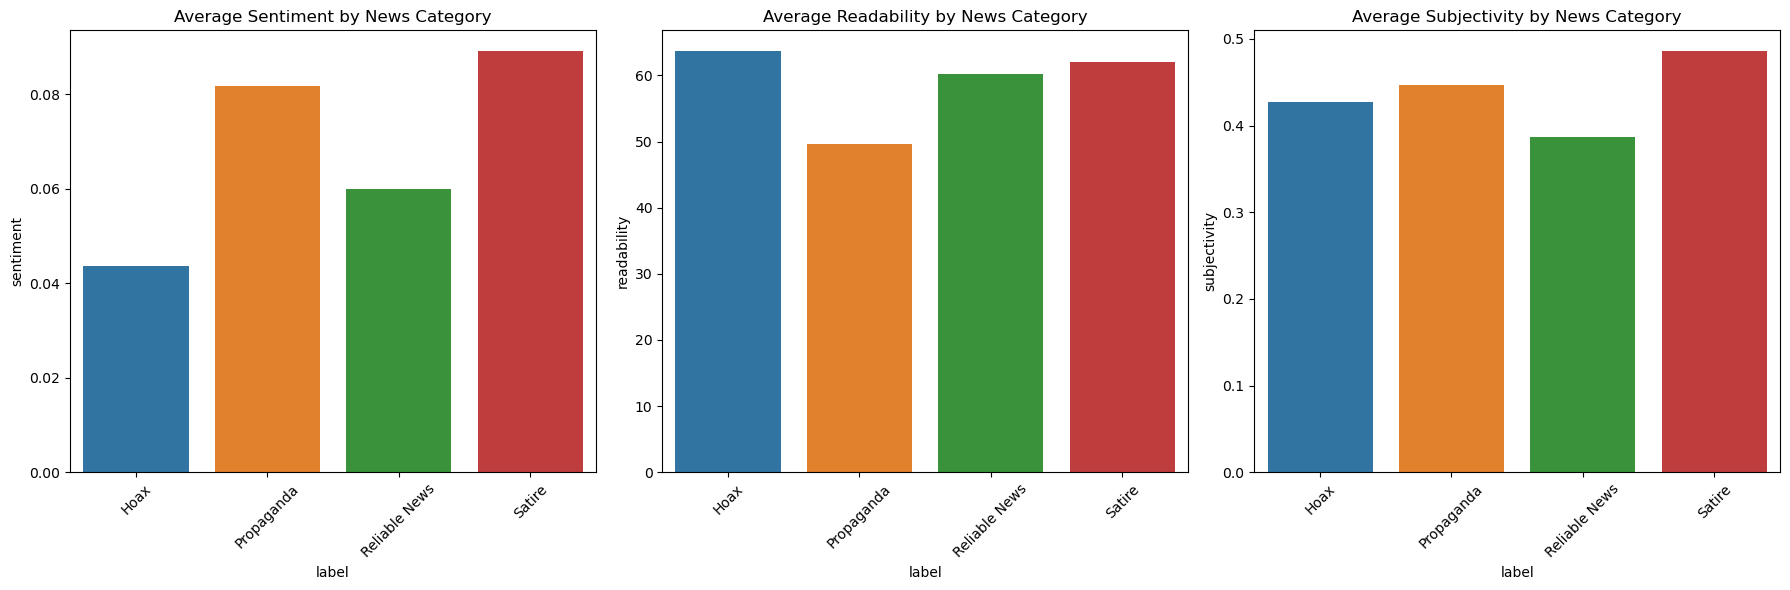

In [35]:
# Calculate mean values for sentiment, readability, and subjectivity by news category
mean_values = df_test.groupby('label').agg({
    'sentiment': 'mean',
    'readability': 'mean',
    'subjectivity': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Sentiment
plt.subplot(1, 3, 1)
sns.barplot(x='label', y='sentiment', data=mean_values)
plt.title('Average Sentiment by News Category')
plt.xticks(rotation=45)

# Readability
plt.subplot(1, 3, 2)
sns.barplot(x='label', y='readability', data=mean_values)
plt.title('Average Readability by News Category')
plt.xticks(rotation=45)

# Subjectivity
plt.subplot(1, 3, 3)
sns.barplot(x='label', y='subjectivity', data=mean_values)
plt.title('Average Subjectivity by News Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Punctuation count, Punctuation diversity, Semantic dispersion

### Train set

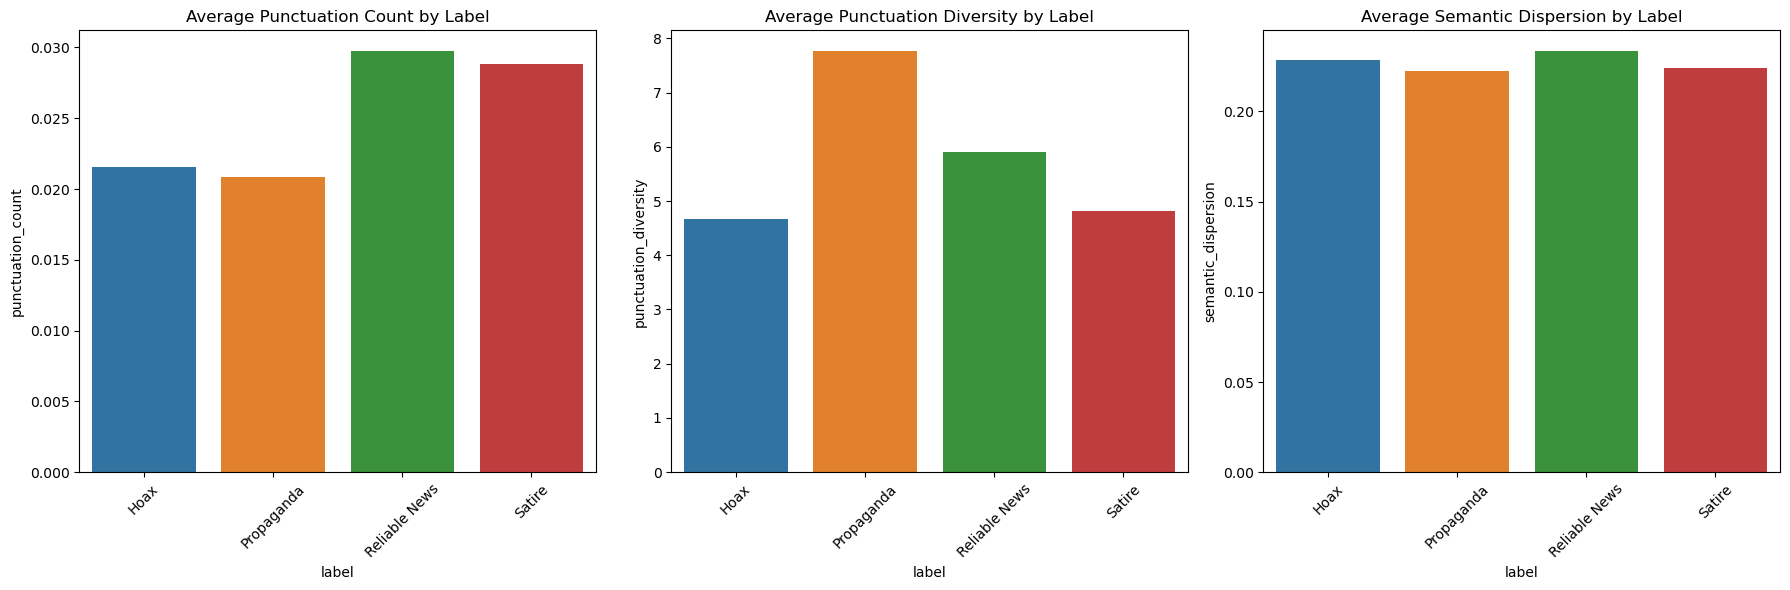

In [36]:
# Calculate mean values for your features by news category
mean_values = df_train.groupby('label').agg({
    'punctuation_count': 'mean',
    'punctuation_diversity': 'mean',
    'semantic_dispersion': 'mean'
}).reset_index()



plt.figure(figsize=(18, 6))

# Punctuation Count
plt.subplot(1, 3, 1)
sns.barplot(x='label', y='punctuation_count', data=mean_values)
plt.title('Average Punctuation Count by Label')
plt.xticks(rotation=45)

# Punctuation Diversity
plt.subplot(1, 3, 2)
sns.barplot(x='label', y='punctuation_diversity', data=mean_values)
plt.title('Average Punctuation Diversity by Label')
plt.xticks(rotation=45)

# Semantic Dispersion
plt.subplot(1, 3, 3)
sns.barplot(x='label', y='semantic_dispersion', data=mean_values)
plt.title('Average Semantic Dispersion by Label')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Test set

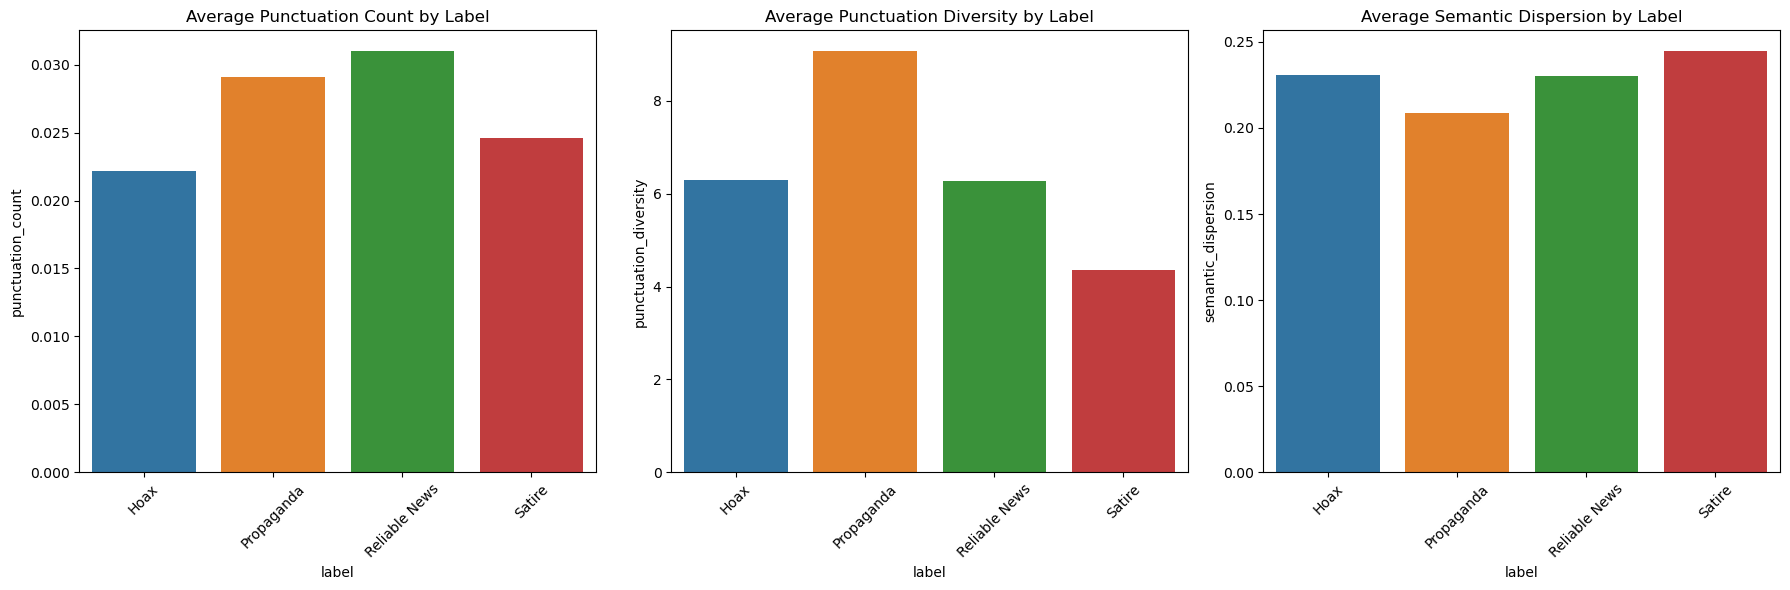

In [37]:
# Calculate mean values for your features by news category
mean_values = df_test.groupby('label').agg({
    'punctuation_count': 'mean',
    'punctuation_diversity': 'mean',
    'semantic_dispersion': 'mean'
}).reset_index()


plt.figure(figsize=(18, 6))

# Punctuation Count
plt.subplot(1, 3, 1)
sns.barplot(x='label', y='punctuation_count', data=mean_values)
plt.title('Average Punctuation Count by Label')
plt.xticks(rotation=45)

# Punctuation Diversity
plt.subplot(1, 3, 2)
sns.barplot(x='label', y='punctuation_diversity', data=mean_values)
plt.title('Average Punctuation Diversity by Label')
plt.xticks(rotation=45)

# Semantic Dispersion
plt.subplot(1, 3, 3)
sns.barplot(x='label', y='semantic_dispersion', data=mean_values)
plt.title('Average Semantic Dispersion by Label')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Model training and evaluation

In [38]:
# Training set
X_train = df_train['processed_text']
y_train = df_train['label']

# Testing set
X_test = df_test['processed_text']
y_test = df_test['label']

## Choose a Vectorizer

In [26]:
# Choose the appropriate vectorizer here
# vectorizer = CountVectorizer(max_features = 10000)
vectorizer = TfidfVectorizer(max_features = 10000)
# vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)

## Vectorize

In [39]:
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Feature Selection

In [41]:
## for POS tagging, choose this one and don't run the next cell
scaler = MinMaxScaler()
pos_feature_names = [f'pos_feature_{i}' for i in range(pos_train.shape[1])]

# Scale the POS features
additional_features_train_scaled = df_train[pos_feature_names]
additional_features_test_scaled = df_test[pos_feature_names]
additional_features_train_scaled = csr_matrix(additional_features_train_scaled)
additional_features_test_scaled = csr_matrix(additional_features_test_scaled)


In [42]:
# For all other features that are not POS tagging
scaler = MinMaxScaler()

'''
Features include word_count, named_entity_count, name_entity_count_per_word, avg_first_person_pronouns,
avg_second_person_pronouns, avg_third_person_pronouns, sentiment, subjectivity, readability, punctuation_count, punctuation_diversity,
punctuation_pair
'''

selected_features = ["punctuation_pair", "named_entity_count_per_word", "avg_third_person_pronouns"]
additional_features_train_scaled = scaler.fit_transform(df_train[selected_features])
additional_features_test_scaled = scaler.transform(df_test[selected_features])

# Combine scaled additional features
X_train_combined = hstack([X_train_counts , additional_features_train_scaled])
X_test_combined = hstack([X_test_counts, additional_features_test_scaled])

## Oversampling

In [ ]:
## If you want to oversample
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

## Logistic Baseline

In [188]:
# Logistic no features
clf = LogisticRegression(max_iter = 1000)

clf.fit(X_train_counts, y_train)

# Predict
y_pred = clf.predict(X_test_counts)

# Score
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

               precision    recall  f1-score   support

         Hoax       0.85      0.41      0.55       750
   Propaganda       0.58      0.85      0.69       750
Reliable News       0.82      0.90      0.86       750
       Satire       0.85      0.83      0.84       750

     accuracy                           0.75      3000
    macro avg       0.78      0.75      0.74      3000
 weighted avg       0.78      0.75      0.74      3000

Macro F1 Score: 0.735


## Logistic with feature engineering 

In [195]:
# Logistic with combined features
clf = LogisticRegression(max_iter = 1000)

clf.fit(X_train_combined, y_train)

# Predict
y_pred = clf.predict(X_test_combined)

# Score
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

               precision    recall  f1-score   support

         Hoax       0.87      0.45      0.60       750
   Propaganda       0.62      0.83      0.71       750
Reliable News       0.83      0.92      0.87       750
       Satire       0.85      0.87      0.86       750

     accuracy                           0.77      3000
    macro avg       0.79      0.77      0.76      3000
 weighted avg       0.79      0.77      0.76      3000

Macro F1 Score: 0.757


# Logistic with oversampling + features

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred = clf.predict(X_test_combined)

# Score
print(classification_report(y_test, y_pred))

# Calculate Macro F1 Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1:.3f}')


## Linear SVM

In [34]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0) 

# Train the SVM classifier
svm_classifier.fit(X_train_counts, y_train)

# Predict on the test data
y_pred = svm_classifier.predict(X_test_counts)

# Evaluate the model
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

               precision    recall  f1-score   support

         Hoax       0.84      0.41      0.55       750
   Propaganda       0.58      0.83      0.68       750
Reliable News       0.80      0.93      0.86       750
       Satire       0.87      0.80      0.83       750

     accuracy                           0.74      3000
    macro avg       0.77      0.74      0.73      3000
 weighted avg       0.77      0.74      0.73      3000

Macro F1 Score: 0.731


## Simple NN

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert sparse matrix to dense matrix
X_train_dense = X_train_counts.toarray()
X_test_dense = X_test_counts.toarray()  # Assuming X_test_counts is also a sparse matrix

# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train_dense, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train_dense), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print("Train Accuracy:", train_accuracy)

Epoch 1/30
1222/1222 [==============================] - 7s 6ms/step - loss: 0.1202 - accuracy: 0.9576 - val_loss: 2.6501 - val_accuracy: 0.4768
Epoch 2/30
1222/1222 [==============================] - 7s 6ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 4.8125 - val_accuracy: 0.3440
Epoch 3/30
1222/1222 [==============================] - 8s 6ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 6.4871 - val_accuracy: 0.3197
Epoch 4/30
1222/1222 [==============================] - 7s 6ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 6.4816 - val_accuracy: 0.3417
Epoch 5/30
1222/1222 [==============================] - 7s 5ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 6.4696 - val_accuracy: 0.2927
Epoch 6/30
1222/1222 [==============================] - 7s 6ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 9.1959 - val_accuracy: 0.2805
Epoch 7/30
1222/1222 [==============================] - 7s 5ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 11.4741 - val_accuracy

In [50]:
# Predict labels for the test dataset
y_pred =np.argmax(model.predict(X_test_dense),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Evaluate the model
print(classification_report(y_test_encoded, y_pred))

macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.69      0.42      0.52       750
           1       0.51      0.92      0.66       750
           2       0.98      0.23      0.37       750
           3       0.58      0.80      0.67       750

    accuracy                           0.59      3000
   macro avg       0.69      0.59      0.56      3000
weighted avg       0.69      0.59      0.56      3000

Macro F1 Score: 0.555


## CNN

In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


# Convert sparse matrix to dense matrix
X_train_dense = X_train_counts.toarray()
X_test_dense = X_test_counts.toarray()  # Assuming X_test_counts is also a sparse matrix

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_dense, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_dense, maxlen=maxlen, padding='post')

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Reshape data for 1D CNN input
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
X_test_padded = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)



# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train_padded , y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)

# Correcting the prediction call to use the padded and reshaped data
y_train_pred = np.argmax(model.predict(X_train_padded), axis=1)

# Calculate accuracy for training dataset
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)

Epoch 1/30
1222/1222 [==============================] - 7s 5ms/step - loss: 1.2085 - accuracy: 0.4567 - val_loss: 2.5245 - val_accuracy: 0.0000e+00
Epoch 2/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0998 - accuracy: 0.4572 - val_loss: 3.2841 - val_accuracy: 0.0000e+00
Epoch 3/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0760 - accuracy: 0.4572 - val_loss: 3.8449 - val_accuracy: 0.0000e+00
Epoch 4/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0675 - accuracy: 0.4572 - val_loss: 4.2850 - val_accuracy: 0.0000e+00
Epoch 5/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0641 - accuracy: 0.4572 - val_loss: 4.6144 - val_accuracy: 0.0000e+00
Epoch 6/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0628 - accuracy: 0.4572 - val_loss: 4.8464 - val_accuracy: 0.0000e+00
Epoch 7/30
1222/1222 [==============================] - 6s 5ms/step - loss: 1.0624 - accuracy: 0.4572 - val_loss

In [61]:
# Predict labels for the test dataset
y_pred =np.argmax(model.predict(X_test_padded),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Evaluate the model
print(classification_report(y_test_encoded, y_pred))

macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       750
           1       0.25      1.00      0.40       750
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       750

    accuracy                           0.25      3000
   macro avg       0.06      0.25      0.10      3000
weighted avg       0.06      0.25      0.10      3000

Macro F1 Score: 0.100


/Users/jonathan/anaconda3/envs/CS4248/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonathan/anaconda3/envs/CS4248/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jonathan/anaconda3/envs/CS4248/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## CNN-LSTM

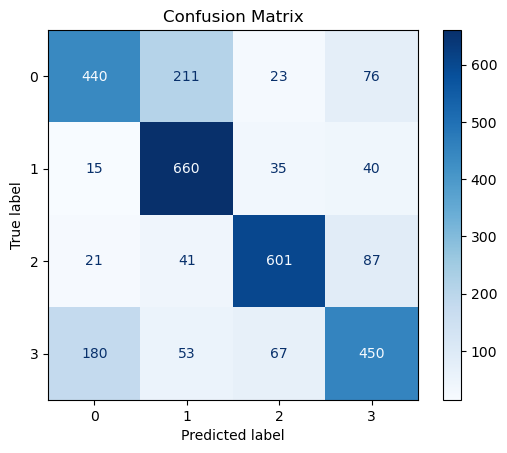

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()